In [93]:
import pickle
import os
import pathlib

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,7)
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras import initializers

In [94]:
DATASET_PATH = 'data/mini_chirps'
data_dir = pathlib.Path(DATASET_PATH)

#if not data_dir.exists():
#  tf.keras.utils.get_file(
#      '?????????.zip',
#      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip (CHANGE)",
#      extract=True,
#      cache_dir='.', cache_subdir='data')

#must name folders w the bird names for below
birds = np.array(tf.io.gfile.listdir(str(data_dir)))
birds = birds[(birds != 'README.md') & (birds != '.DS_Store')]
print('Birds Available:', birds)

Birds Available: ['nuttalls_woodpecker' 'northern_cardinal' 'bushtit' 'red_tailed_hawk'
 'peregrine_falcon' 'rock_pigeon' 'house_sparrow' 'western_bluebird'
 'black_crowned_night_heron' 'common_raven']


In [95]:
# train/val split
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=10, #num audio files per batch (per bird)
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000, #num audio samples in each file
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label :", label_names)

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Found 100 files belonging to 10 classes.
Using 80 files for training.
Using 20 files for validation.

label : ['black_crowned_night_heron' 'bushtit' 'common_raven' 'house_sparrow'
 'northern_cardinal' 'nuttalls_woodpecker' 'peregrine_falcon'
 'red_tailed_hawk' 'rock_pigeon' 'western_bluebird']


In [124]:
#Convert waveforms to spectograms

#The waveforms must be the same length for the resulting spectrograms to have equal dimensions. 
#Simply zero-padding the Audio segments under one second will accomplish this (using tf.zeros).

def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension so that the Spectrogram can be used
  spectrogram = spectrogram[..., tf.newaxis]
  assert spectrogram.shape[1:] == (124, 129, 1), f"Unexpected shape: {spectrogram.shape}"
  return spectrogram

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

def debug_shapes(audio, label):
    print("Audio shape:", audio.shape, "Label shape:", label.shape)
    return audio, label

#train_spectrogram_ds = train_spectrogram_ds.map(debug_shapes)
#val_spectrogram_ds = val_spectrogram_ds.map(debug_shapes)

#for audio, label in train_spectrogram_ds.take(9):  # Adjust the number taken as needed
#    print("Label:", label.numpy())

In [135]:
## Initiate classifier and train it using the spectrograms
## make sure you instantiate your classifier and name it model
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(124, 129, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense((10), activation='softmax'))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
#metrics: tf.keras.metrics.Recall(), tf.keras.metrics.Precision()
#for x, y in train_spectrogram_ds.take(80):
#    print(model.predict(x).shape)

#for x, y in train_spectrogram_ds.take(1):
#    try:
#        print("Output shape:", model(x).shape)
#        print("Label shape:", y.shape)
#    except Exception as e:
#        print("Error during trial run:", e)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_85 (Conv2D)              │ (None, 122, 127, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 120, 125, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 240000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │    30,720,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,723,898 (117.20 MB)

 Trainable params: 30,723,898 (117.20 MB)

 Non-trainable params: 0 (0.00 B)

In [136]:
## train your model
## may need to change epochs value
model.fit(train_spectrogram_ds, epochs=80, validation_data=test_spectrogram_ds)

Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step - accuracy: 0.1699 - loss: 3.3131 - val_accuracy: 0.4000 - val_loss: 1.8319
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - accuracy: 0.8211 - loss: 0.9160 - val_accuracy: 0.4000 - val_loss: 1.7552
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.7918 - loss: 0.8813 - val_accuracy: 0.3000 - val_loss: 1.5677
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.8234 - loss: 0.4775 - val_accuracy: 0.4000 - val_loss: 1.7304
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - accuracy: 0.9047 - loss: 0.3002 - val_accuracy: 0.6000 - val_loss: 2.0179
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - accuracy: 0.9044 - loss: 0.2808 - val_accuracy: 0.4000 - val_loss: 3.4825
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - accuracy: 0.8704 - loss: 0.2783 - val_accuracy: 0.5000 - val_loss: 3.1118
Epoch 8/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.9374 - loss: 0.1535 - val_accuracy: 0.5000 - val_loss:

In [138]:
## test the accuracy of your model
#loss,acc = model.evaluate(X_test, y_test)

In [146]:
## making prediction for an input data
audio, labels = train_spectrogram_ds.take(2)
yhat = model.predict(audio)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2024-05-02 12:56:01.343009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


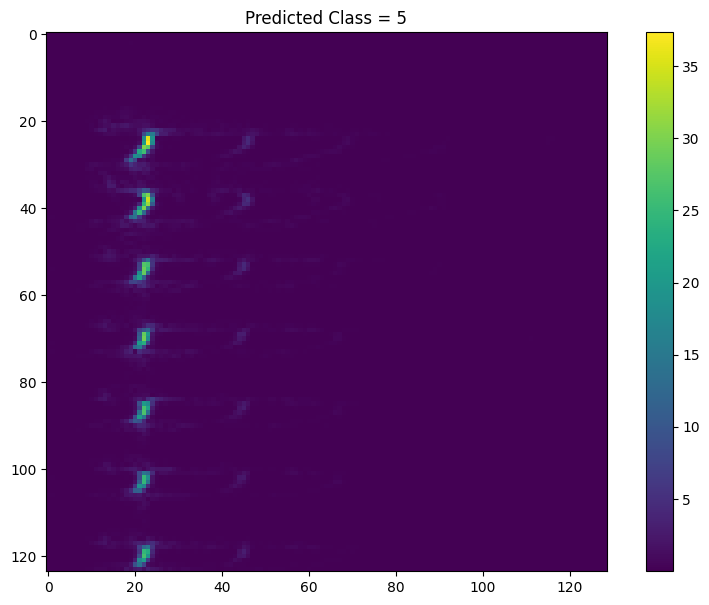

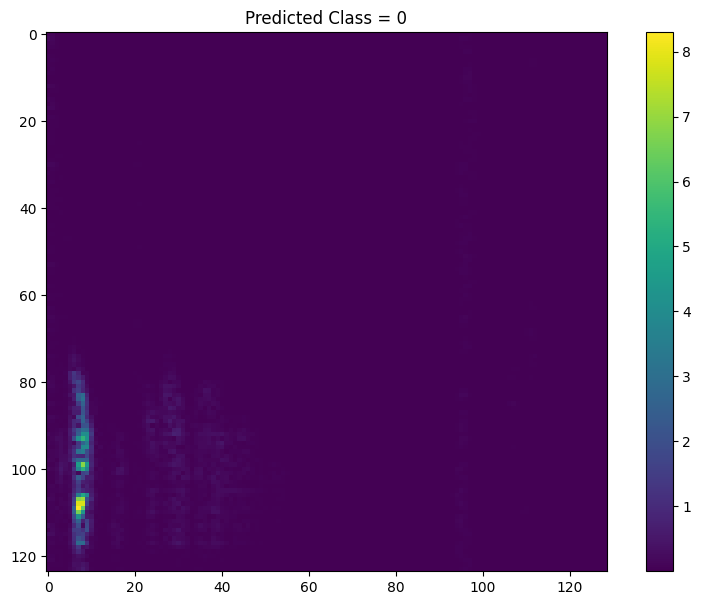

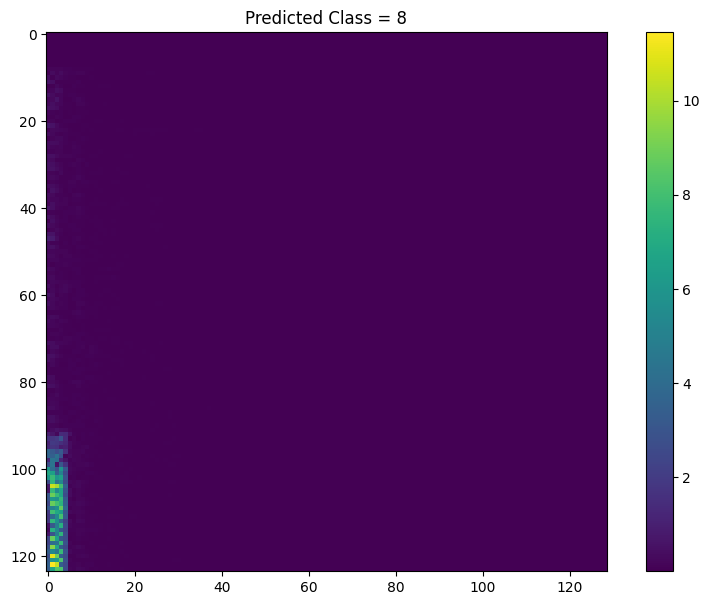

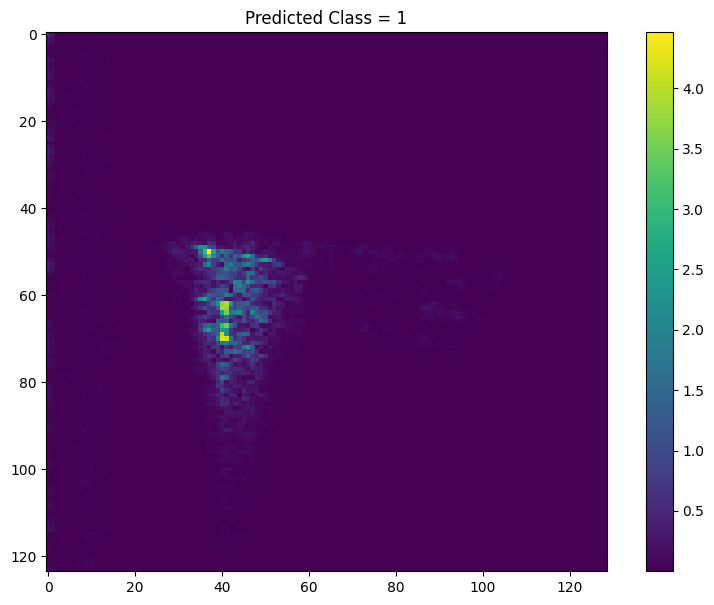

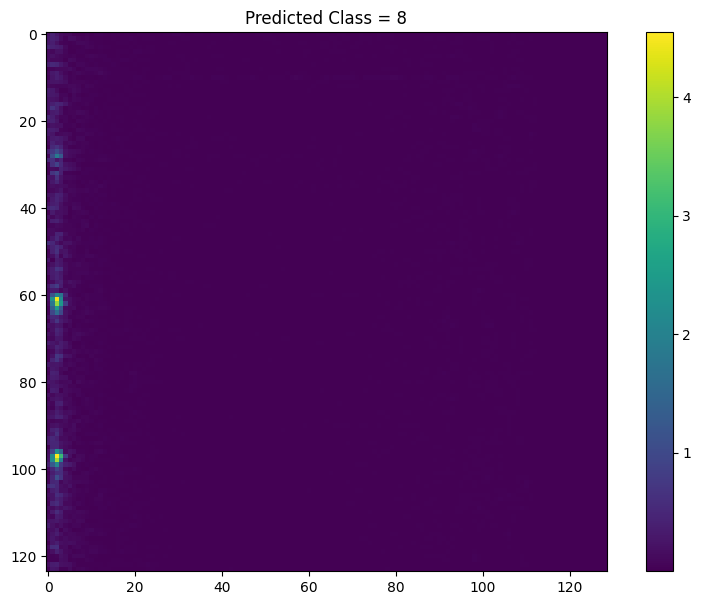

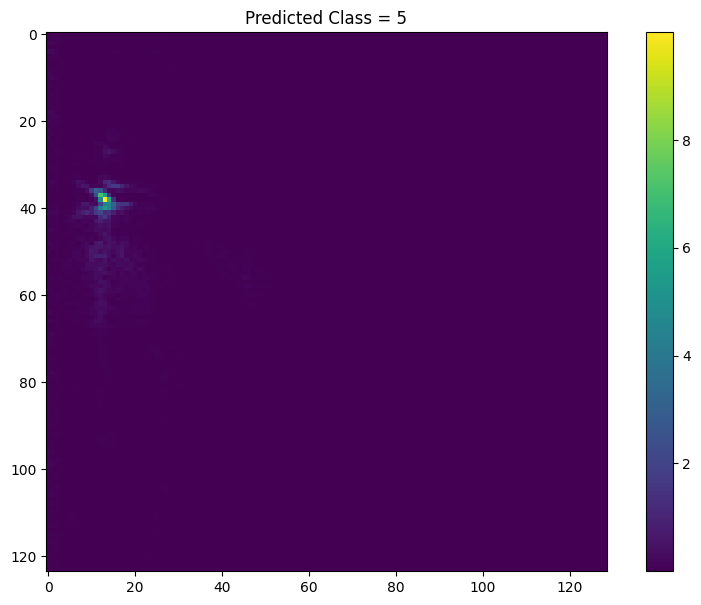

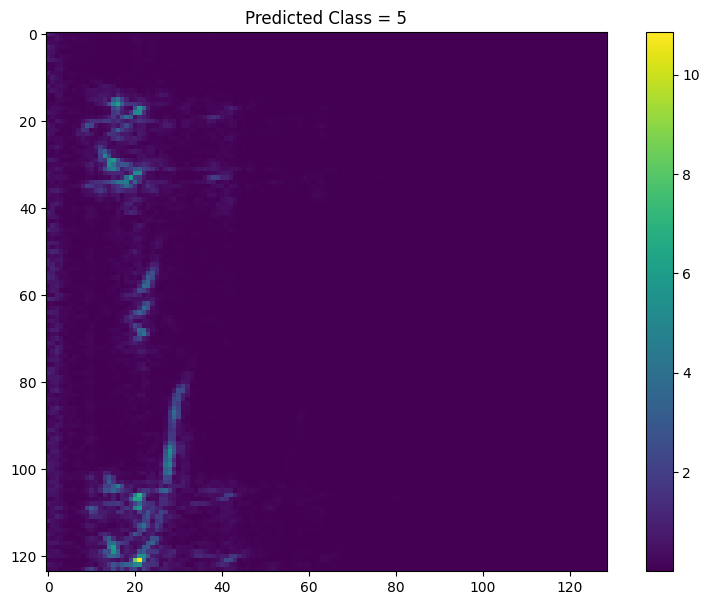

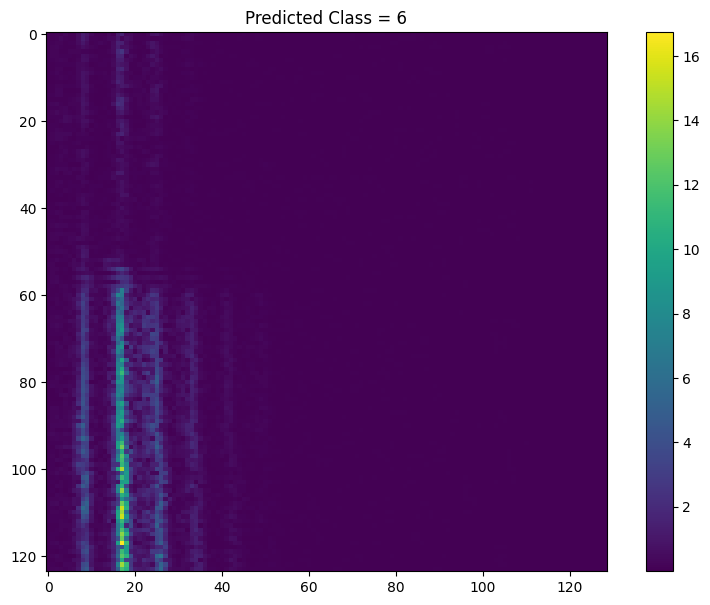

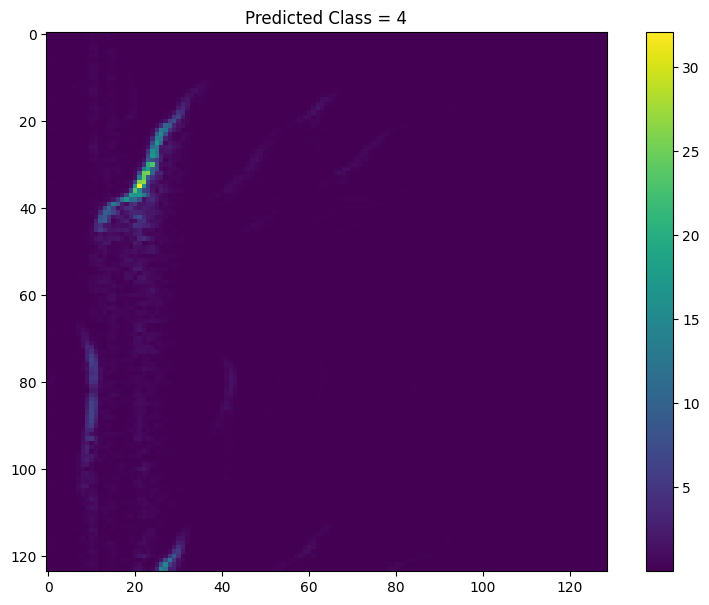

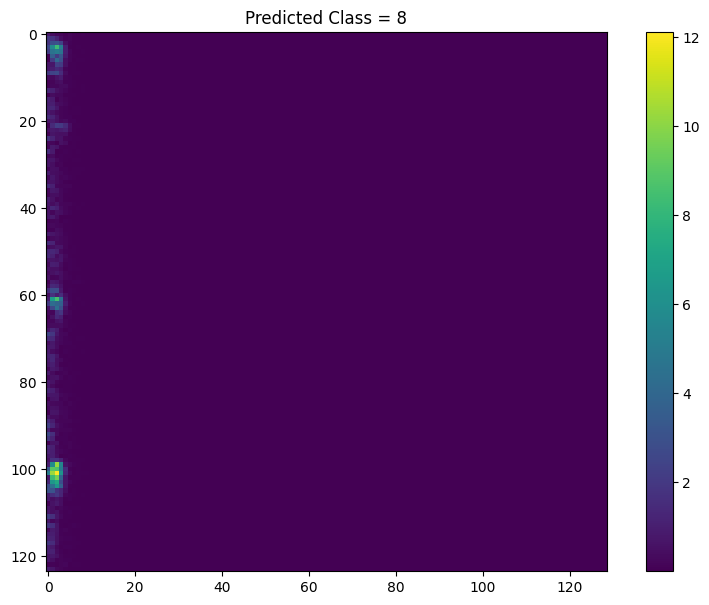

2024-05-02 13:02:18.439447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [156]:
for audio, labels in train_spectrogram_ds.take(1):  # Just take one batch
    yhat = model.predict(audio)  # Predict the batch
    predictions = np.argmax(yhat, axis=1)  # Get the predicted class index

    for j in range(audio.shape[0]):  # Loop through the batch
        plt.figure(figsize=(10, 7))
        plt.imshow(audio[j, :, :, 0], cmap='viridis')  # Visualize the first channel of the j-th spectrogram
        plt.title(f"Predicted Class = {predictions[j]}")
        plt.colorbar()
        plt.show()

## plot input images with output label
#for i in zip(audio,yhat):
#    print(i[0].shape)
#    plt.figure(figsize=(30,20))
#    plt.text(0, 0, "Predicted Class = "+str(i[1])[0],fontsize = 33,
#         bbox = dict(facecolor = 'red', alpha = 0.2))
#    plt.imshow(np.transpose(i[0])[0])
#    plt.show()

In [157]:
# dump your classifier 
model.save('model.h5')

In [158]:
# test saved model
from keras.models import load_model
loaded_model = load_model('model.h5')

## test the accuracy of your loaded model and compare
#loss,acc = model.evaluate(X_test, y_test)

NameError: name 'X_test' is not defined